In [1]:
#generate location and reward data
import numpy as np
N_locations = 50
N_samples = 100000
p0 = np.arange(N_locations)/10.0 
sigma = 0.5*p0
locations_list = []
rewards_list = []
for idx in range(N_samples):
    location = np.random.randint(0, N_locations)
    p = p0[location]
    s = sigma[location]
    reward = np.random.normal(loc=p, scale=s)
    location_vector = np.zeros(N_locations, dtype=float)
    location_vector[location] += 1.0
    locations_list += [location_vector]
    rewards_list += [reward]
locations = np.array(locations_list)
rewards = np.array(rewards_list)
print locations[0:5]
print rewards[0:5]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0

In [2]:
#test-train-validation split
rn_seed = 13
train_fraction = 0.67
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = \
    train_test_split(locations, rewards, train_size=train_fraction, random_state=rn_seed)
x_test, x_validate, y_test, y_validate = \
    train_test_split(x_test_validate, y_test_validate, train_size=train_fraction, random_state=rn_seed)
print locations.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

(100000, 50)
(67000, 50) (67000,)
(22110, 50) (22110,)
(10890, 50) (10890,)


/Users/joe/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
#this helper function builds an MLP neural network
def mlp_model(N_inputs, layers):
    from keras.models import Sequential
    model = Sequential()
    from keras.layers import Dense
    N = layers[0]
    model.add(Dense(N, activation='elu', input_shape=(N_inputs,)))
    for N in layers[1:-1]:
        model.add(Dense(N, activation='elu'))
    N = layers[-1]
    model.add(Dense(N, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [4]:
#make MLP model
N_inputs = N_locations
N_outputs = 1
layers = [N_locations, N_locations/2, N_outputs]
print 'layers = ', layers
model = mlp_model(N_inputs, layers)
model.summary()

layers =  [50, 25, 1]


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
_________________________________________________________________


In [11]:
#train model to predict rewards
N_epochs = 5
batch_size = N_samples/100
model = mlp_model(N_inputs, layers)
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

In [12]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

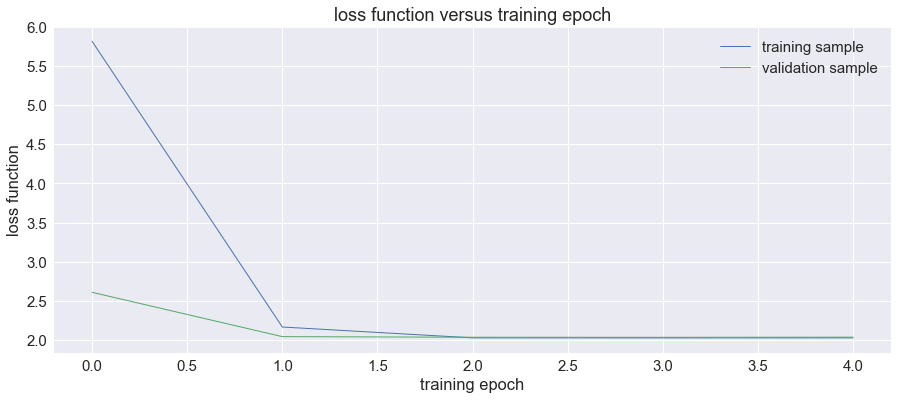

In [13]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, linewidth=1, label='validation sample')
ax.set_title('loss function versus training epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()

In [14]:
#generate predictions dataframe
y_test_pred = model.predict(x_test)
import pandas as pd
cols = range(N_locations)
test = pd.DataFrame(x_test, columns=cols).astype(int)
test['y_test'] = y_test
test['y_test_pred'] = y_test_pred
test.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,y_test,y_test_pred
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.824870,1.148254
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1.333425,0.755119
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.704212,3.297861
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.513282,1.468095
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.137923,2.910367


In [15]:
#show that the predicted value=mean of actuals
agg_dict = {'y_test':['count', 'mean', 'std'], 'y_test_pred':['mean']}
test_grouped = test.groupby(cols, as_index=False).agg(agg_dict)
test_grouped

0  1  2  3  4  5  6  7  8  9    ...    44 45 46 47 48 49 y_test_pred  \
                                    ...                             mean   
0   0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  1    4.869924   
1   0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  1  0    4.793501   
2   0  0  0  0  0  0  0  0  0  0    ...     0  0  0  1  0  0    4.554683   
3   0  0  0  0  0  0  0  0  0  0    ...     0  0  1  0  0  0    4.543172   
4   0  0  0  0  0  0  0  0  0  0    ...     0  1  0  0  0  0    4.614366   
5   0  0  0  0  0  0  0  0  0  0    ...     1  0  0  0  0  0    4.381659   
6   0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    4.320946   
7   0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    4.194023   
8   0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    4.131219   
9   0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    4.053564   
10  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.890165   
11  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.832449   
12  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.626532   
13  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.568326   
14  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.517038   
15  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.367480   
16  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.297861   
17  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.165745   
18  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.045868   
19  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    3.112737   
20  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.910367   
21  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.781109   
22  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.698330   
23  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.609001   
24  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.512504   
25  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.330599   
26  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.325383   
27  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.297111   
28  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    2.235422   
29  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.993967   
30  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.894162   
31  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.796546   
32  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.731132   
33  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.764146   
34  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.501640   
35  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.468095   
36  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.313309   
37  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.250644   
38  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.148254   
39  0  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    1.026360   
40  0  0  0  0  0  0  0  0  0  1    ...     0  0  0  0  0  0    0.900864   
41  0  0  0  0  0  0  0  0  1  0    ...     0  0  0  0  0  0    0.755119   
42  0  0  0  0  0  0  0  1  0  0    ...     0  0  0  0  0  0    0.710871   
43  0  0  0  0  0  0  1  0  0  0    ...     0  0  0  0  0  0    0.615773   
44  0  0  0  0  0  1  0  0  0  0    ...     0  0  0  0  0  0    0.529148   
45  0  0  0  0  1  0  0  0  0  0    ...     0  0  0  0  0  0    0.428598   
46  0  0  0  1  0  0  0  0  0  0    ...     0  0  0  0  0  0    0.304679   
47  0  0  1  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    0.202016   
48  0  1  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    0.107045   
49  1  0  0  0  0  0  0  0  0  0    ...     0  0  0  0  0  0    0.000786   

   y_test                      
    count      mean

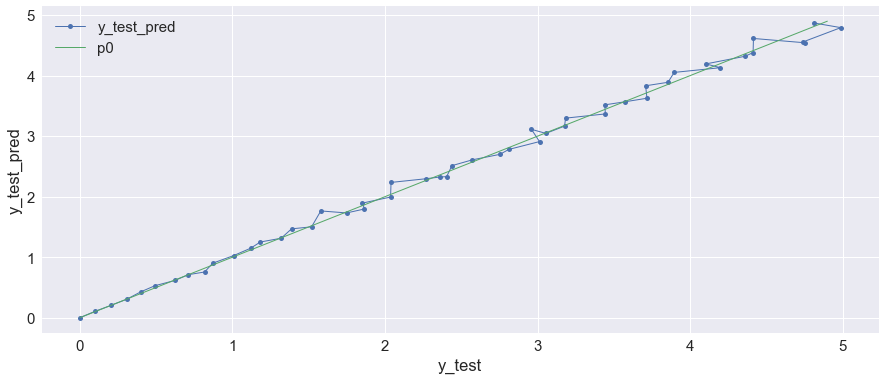

In [16]:
#plot y_test_pred vs p0
df = test_grouped
xp = df['y_test']['mean']
yp = df['y_test_pred']['mean']
fig, ax = plt.subplots(1,1, figsize=(15, 6))
p = ax.plot(xp, yp, marker='o', markersize=5, linewidth=1, label='y_test_pred')
p = ax.plot(p0, p0, linewidth=1, label='p0')
p = ax.set_ylabel('y_test_pred')
p = ax.set_xlabel('y_test')
p = ax.legend()